In [157]:
import numpy as np
import jax.numpy as jnp

import jax
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

is_dark = False
theme, cs = rp.mpl_setup(is_dark)
rp.plotly_setup(is_dark)

In [2]:
%cd ~/cdv

/home/nmiklaucic/cdv


In [3]:
clean = pd.read_pickle('precomputed/jarvis_dft3d_cleaned/dataframe.pkl')
clean

,space_group,formula,e_form,bandgap,atoms,e_total,ehull,dimensionality,density,num_atoms,num_spec,magmom
0,129,"(Ti, Cu, Si, As)",-0.42762,0.0,"[[2.67519992 2.67519992 7.37609819] Ti, [0.891...",-3.37474,0.0423,3D-bulk,5.956,8,4,0.000
1,221,"(Dy, B)",-0.41596,0.0,"[[0. 0. 0.] Dy, [0.81214866 2.04453946 2.04453...",-5.79186,0.0456,3D-bulk,5.522,7,2,0.000
2,119,"(Be, Os, Ru)",0.04847,0.0,"[[0. 0. 0.] Be, [1.83359072 0. 1.74248...",-4.65924,0.3183,intercalated ion,10.960,4,3,0.000
4,164,"(V, Se)",-0.71026,0.0,"[[0. 0. 0.] V, [ 1.67774838 -0.96865035 4.652...",-3.87823,0.0156,2D-bulk,5.718,3,2,0.000
5,62,"(Tb, Mn, Si)",-0.45468,0.0,"[[1.03935903 3.52971335 1.38135171] Tb, [3.118...",-4.35889,0.0817,3D-bulk,7.410,12,3,8.916
...,...,...,...,...,...,...,...,...,...,...,...,...
75980,164,"(Nd, Mg, Sb)",-0.69038,0.0,"[[0. 0. 0.] Nd, [2.3394364 1.35070495 2.69383...",-1.53096,0.0000,3D-bulk,5.116,5,3,0.000
75983,216,"(Yb, Pr, Pd)",-0.56635,0.0,"[[5.25036997 5.25036997 5.25036997] Yb, [1.750...",-1.70796,0.0000,3D-bulk,8.139,3,3,0.000
75984,216,"(Tb, Tl, Zn)",-0.29921,0.0,"[[1.66349368 1.66349368 1.66349368] Tb, [4.990...",0.05135,0.0000,3D-bulk,9.666,3,3,0.000
75989,216,"(Pr, Tl, Zn)",-0.34112,0.0,"[[1.71052992 1.71052992 1.71052992] Pr, [5.131...",-0.10696,0.0000,3D-bulk,8.517,3,3,0.000


In [4]:
elements = set()
for struct in clean['atoms']:
    elements.update(set(struct.elements))

print(' '.join([e.symbol for e in sorted(elements)]))
# print(elements)
# print({e.symbol: (e.average_ionic_radius, e.atomic_radius) for e in elements})

K Rb Ba Na Sr Li Ca La Tb Yb Ce Pr Nd Sm Dy Y Ho Er Tm Hf Mg Zr Sc U Ta Ti Mn Be Nb Al Tl V Zn Cr Cd In Ga Fe Co Cu Si Ni Ag Sn Hg Ge Bi B Sb Te Mo As P H Ir Os Pd Ru Pt Rh Pb W Au C Se S I Br N Cl O F


In [5]:
cutoff = 7.0
max_num_neighbors = 20

graphs = []

def radius_graph(struct):
    graph_ijs = []
    graph_ims = []

    for i, nbs in enumerate(struct.get_all_neighbors(cutoff)):
        if nbs:
            sites, dists, idxs, ims = zip(*nbs)
            # select the first max_num_neighbors
            chosen = np.argsort(dists)[:max_num_neighbors]

            graph_ijs.append(np.vstack([np.ones_like(chosen) * i, np.array(idxs)[chosen]]))
            graph_ims.append(np.array(ims)[chosen])

    if graph_ijs:
        graph_ijs = np.concatenate(graph_ijs, axis=1).T.astype(np.uint16)
        graph_ims = np.concatenate(graph_ims).astype(np.int8)

        return graph_ijs, graph_ims
    else:
        # no atoms: return the empty list, filter it out later
        return np.array([]).astype(np.uint16), np.array([]).astype(np.int8)

In [6]:
from multiprocessing import Pool
import warnings

warnings.simplefilter('ignore', category=UserWarning)

with Pool(processes=32) as P:
    graphs = P.map(radius_graph, clean['atoms'])

/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
# from pymatgen.core import Structure
# from pymatgen.analysis.graphs import StructureGraph
# from pymatgen.analysis.local_env import CrystalNN
# from tqdm import tqdm
# import warnings
# nn = CrystalNN()

# from multiprocessing import Pool

# warnings.simplefilter('ignore', category=UserWarning)

# with Pool(processes=48) as P:
#     graphs = P.map(nn.get_bonded_structure, clean['atoms'])

In [7]:
import pickle

if 'graphs' in globals() or 'graphs' in locals():
    print('Saving...')
    with open('precomputed/jarvis_dft3d_cleaned/graphs.pkl', 'wb') as out:
        pickle.dump(graphs, out)
else:
    print('Loading...')
    with open('precomputed/jarvis_dft3d_cleaned/graphs.pkl', 'rb') as out:
        graphs = pickle.load(out)

Saving...


We want to split the samples into batches. Because Jax needs fixed shapes, we're going to pad
batches to the same number of nodes and edges. This means that we want to sort into batches such
that the max number of edges in a batch is minimized, ideally just below a power of 2. That's what
the below code does.

It's also nice if the number of batches splits cleanly.

In [9]:
from sympy import factorint
n_data = len(clean.index)
for power in range(1, 11):
    bs = 2 ** power - 1
    rem = n_data % bs
    factorstr = '\t'.join((f'{k}^{v}' for k, v in factorint(n_data - rem).items()))
    print(f'{bs:>4}\t{rem:>4}\t{factorstr}')

   1	   0	2^1	30893^1
   3	   1	3^2	5^1	1373^1
   7	   4	2^1	3^1	7^1	1471^1
  15	   1	3^2	5^1	1373^1
  31	   3	31^1	1993^1
  63	  46	2^2	3^2	5^1	7^3
 127	  64	2^1	3^5	127^1
 255	  76	2^1	3^1	5^1	11^2	17^1
 511	 466	2^3	3^1	5^1	7^1	73^1
1023	 406	2^2	3^2	5^1	11^1	31^1


In [46]:
batch_size = 62

In [59]:
from tqdm import tqdm
import functools as ft

graph_inds = np.array([i for i in range(len(graphs)) if len(graphs[i][0]) > 0])

if hasattr(graphs[0], 'graph'):
    # using networkx
    # each edge is split into 2 directed edges
    sizes = np.array([(len(g.graph.nodes), 2 * len(g.graph.edges)) for g in graphs[:-3]])
else:
    # using custom arrays
    sizes = np.array([(np.max(ijs) + 1, ijs.shape[0]) for ijs, ims in graphs if len(ijs) > 0])

def get_parts(numbers, batch, chunk_size):    
    # assert len(numbers) % (batch * chunk_size) == 0
    n_batches = len(numbers) // batch
    parts = np.zeros((batch, n_batches), dtype=jnp.int32)
    part_sizes = np.array([0 for _ in range(n_batches)])
    
    chunk_i = 0
    for sample_is in tqdm(np.argsort(-numbers).reshape(batch // chunk_size, chunk_size * n_batches)):
        sample_sizes = numbers[sample_is]
        n_filled = np.zeros((n_batches,), dtype=jnp.int32)
        for sample_i, sample_size in zip(sample_is, sample_sizes):
            next_i = np.argmin(part_sizes + 10000 * (n_filled == chunk_size))
            parts[chunk_i * chunk_size + n_filled[next_i], next_i] += sample_i
            n_filled[next_i] += 1
            part_sizes[next_i] += sample_size
        chunk_i += 1

    return parts, part_sizes

# TODO in the future we should probably pad instead of cutting, but at this point it's fine
num_remove = sizes.shape[0] % batch_size

parts, part_sizes = get_parts(sizes[:-num_remove, 0], batch_size, batch_size)
parts_orig_i = graph_inds[parts]
print(part_sizes)

100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

[504 504 504 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503
 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503
 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502
 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502
 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502
 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502
 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502
 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502
 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502
 502 502 502 502 502 502 502 502 502 502 502 502 502 502 502 501 501 501
 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501
 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501
 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501
 501 501 501 501 501 501 501 501 501 501 501 501 50

In [60]:
print(batch_size)
for ax in (0, 1):
    max_size = max(jnp.take(sizes[:, ax], parts).sum(axis=0))

    # pad to multiple of 64 for tensor cores
    pad_size = max_size + 16 - (max_size % 16)
    print(max_size, '\t', pad_size)

62
504 	 512
10080 	 10096


In [61]:
jnp.save('precomputed/jarvis_dft3d_cleaned/batches.npy', parts_orig_i)

In [ ]:
recv = jnp.array([4, 1, 1, 2, 2, 3])
edge = jnp.array([0, 2, 3, 1, 1, 4])
nodes = jnp.array([4, 3, 2, 1, 0])

In [ ]:
jax.ops.segment_sum(recv, edge)

In [ ]:
'{:.4g}'.format(3.14159)

In [ ]:
np.array([0]).dtype.kind

In [235]:
from dataclasses import dataclass


@dataclass
class Bessel1DBasis:
    """Uses spherical Bessel functions with a cutoff, as in DimeNet++."""
    num_basis: int = 7
    cutoff: float = 1
    # Controls how fast the envelope goes to 0 at the cutoff.
    envelope_exp: int = 5

    def setup(self):
        def freq_init(rng):
            return jnp.arange(self.num_basis, dtype=jnp.float32) + 1
        self.freq = freq_init(None) 

    def __call__(self, x):
        dist = x[..., None] / self.cutoff
        env = 1

        # e(d) = sqrt(2/c) * sin(fπd/c)/d
        # we use sinc so it's defined at 0
        # jnp.sinc is sin(πx)/(πx)
        # e(d) = sqrt(2/c) * sin(πfd/c)/(fd/c) * f/c
        # e(d) = sqrt(2/c) * sinc(πfd/c)/(πfd/c) * πf/c

        e_d = jnp.sqrt(2 / self.cutoff) * jnp.sinc(self.freq * dist) * jnp.pi * self.freq / self.cutoff

        # debug_stat(dist=dist, env=env, freqs=freqs)
        return env * e_d
    
env = Bessel1DBasis(6)
env.setup()

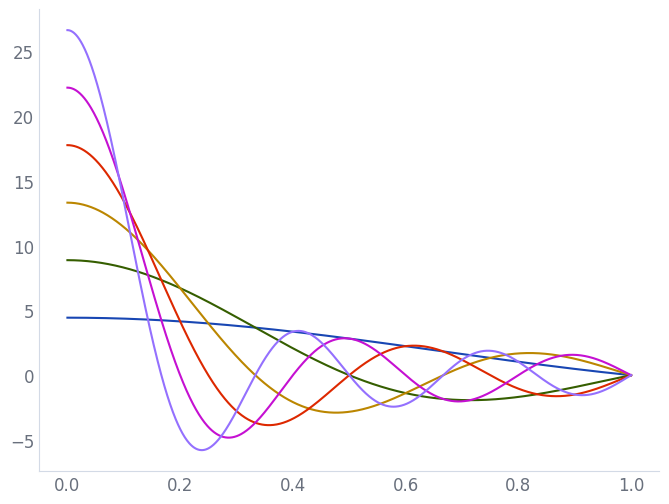

In [236]:
xx = jnp.linspace(0, env.cutoff, 1000)
plt.plot(xx, env(xx))

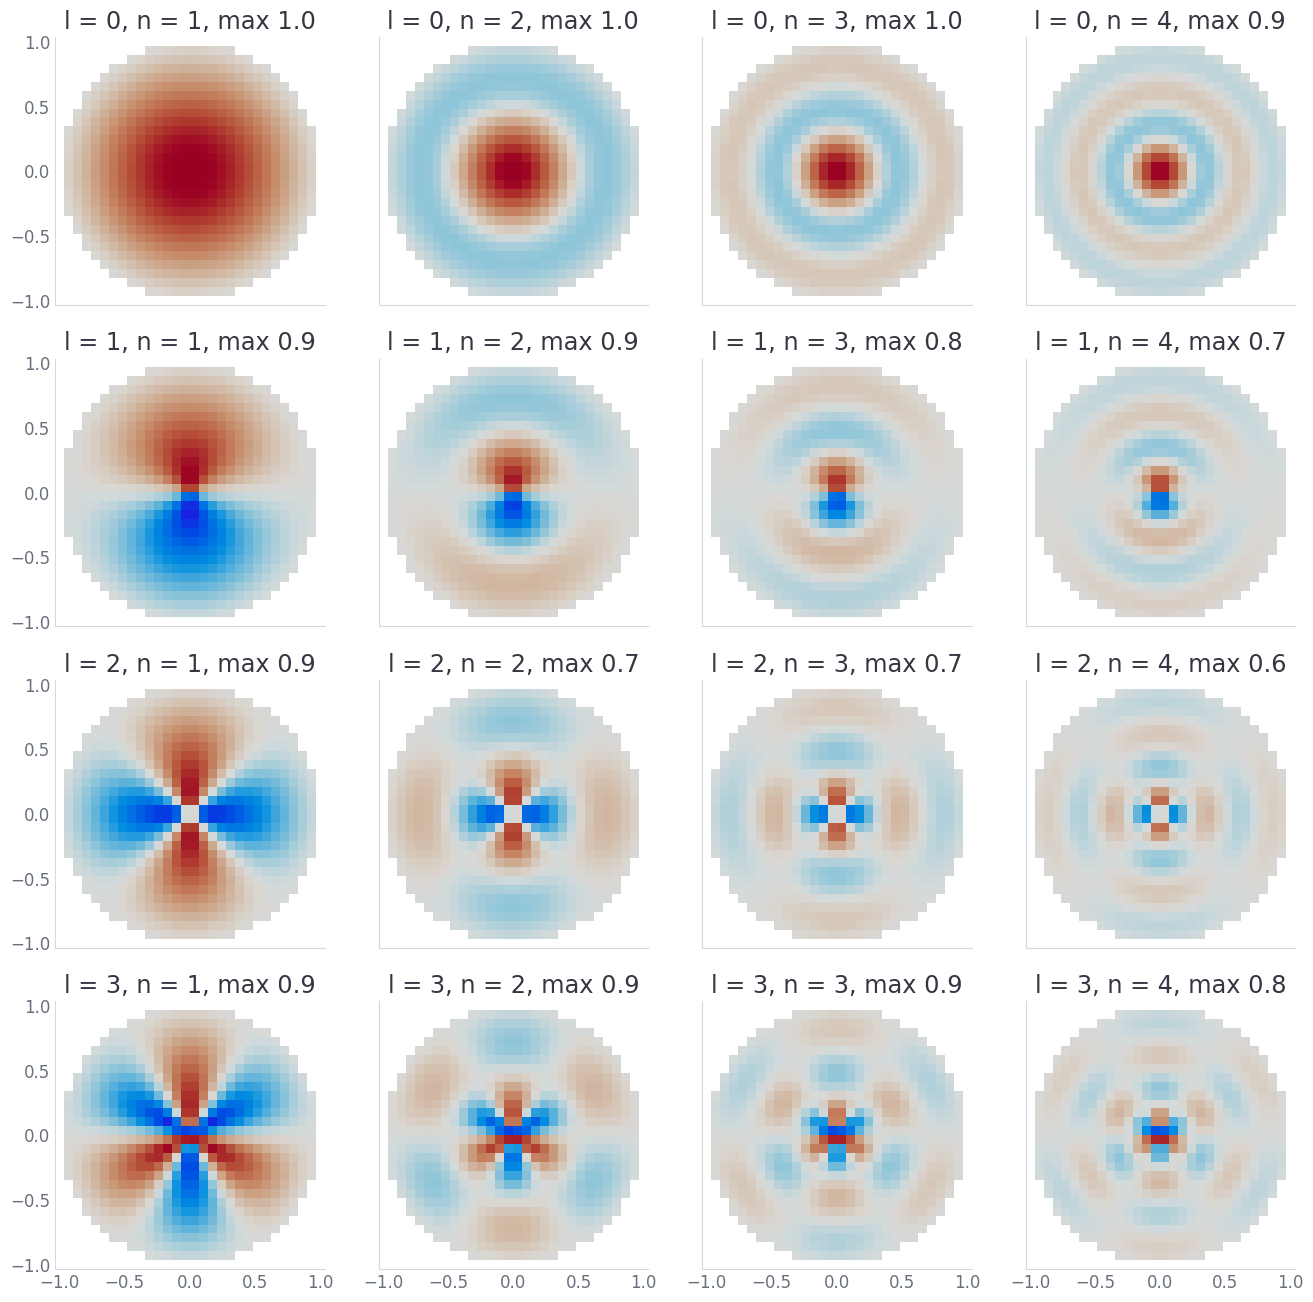

In [270]:
from scipy.interpolate import CloughTocher2DInterpolator as Interpolator
c = 1

da = jnp.mgrid[0.02:c:20j, 0:2*jnp.pi:40j]

fig, axs = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)

env = Bessel1DBasis(6, cutoff=c)
env.setup()

for row, l in enumerate(range(4)):
    for col, n in enumerate(range(1, 5)):


        dd, aa = da.reshape(2, -1)
        xx = dd * jnp.sin(aa)
        yy = dd * jnp.cos(aa)

        z_ln = jn_zeros(l, n)[-1]

        zz = env(dd)[:, n - 1] / env(dd * 0)[:, n - 1] * jnp.cos(aa * l)

        interp = Interpolator(list(zip(xx, yy)), zz)

        grid_xx, grid_yy = np.mgrid[-1:1:30j, -1:1:30j]
        grid_zz = interp(grid_xx, grid_yy)

        abs_max = np.nanmax(np.abs(grid_zz))

        axs[row][col].pcolormesh(grid_xx, grid_yy, grid_zz, shading='auto', cmap='rho_diverging', vmin=-1, vmax=1)
        axs[row][col].set_title(f'l = {l}, n = {n}, max {abs_max:.1f}')

In [271]:
edge_ij = jnp.vstack((np.random.randint(0, 10, 15), np.random.randint(0, 10, 15)))
edge_ij

Array([[6, 3, 1, 2, 5, 2, 7, 0, 4, 5, 9, 8, 3, 5, 7],
       [5, 0, 6, 3, 1, 4, 0, 3, 5, 1, 3, 2, 9, 2, 6]], dtype=int32)

In [279]:
np.where(edge_ij[1][:, None] == edge_ij[0][None, :])

(array([ 0,  0,  0,  1,  2,  3,  3,  4,  5,  6,  7,  7,  8,  8,  8,  9, 10,
        10, 11, 11, 12, 13, 13, 14]),
 array([ 4,  9, 13,  7,  0,  1, 12,  2,  8,  7,  1, 12,  4,  9, 13,  2,  1,
        12,  3,  5, 10,  3,  5,  0]))